In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Instalamos las siguientes librerias y modelos:

* **language_tool_python**: detectar y corregir errores gramaticales, ortográficos y de estilo en textos
* **contractions**: Expansión de contracciones en inglés
* **en_core_web_sm**: Modelo de Tokenización, Lematización, etc

In [12]:
!python -m spacy download en_core_web_sm
!pip install language_tool_python
!pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 43.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import spacy
import nltk
import language_tool_python
import contractions
from nltk.sentiment import SentimentIntensityAnalyzer
#from nltk.tokenize import sent_tokenize
#from nltk.tokenize import word_tokenize
from textblob import TextBlob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics.pairwise import cosine_similarity
nlp = spacy.load("en_core_web_sm")

In [14]:
#import nltk
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('punkt_tab')
nltk.download("vader_lexicon")
lg_tool = language_tool_python.LanguageTool('en-US')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Configuración de librerias

In [15]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [16]:
ROOT_PATH = '/content/drive/Othercomputers/Mi MacBook Pro/Google Drive/tp3'

In [17]:
dataset_file_name = '/trainingandtestdata/tweets_cleaned.csv'

In [18]:
df = pd.read_csv(ROOT_PATH + dataset_file_name)

In [19]:
df

,Text,Polarity
0,"@stellargirl I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right.",4
1,Reading my kindle2... Love it... Lee childs is good read.,4
2,"Ok, first assesment of the #kindle2 ...it fucking rocks!!!",4
3,@kenburbary You'll love your Kindle2. I've had mine for a few months and never looked back. The new big one is huge! No need for remorse! :),4
4,@mikefish Fair enough. But i have the Kindle2 and I think it's perfect :),4
...,...,...
493,Ask Programming: LaTeX or InDesign?: submitted by calcio1 [link] [1 comment] http://tinyurl.com/myfmf7,2
494,"On that note, I hate Word. I hate Pages. I hate LaTeX. There, I said it. I hate LaTeX. All you TEXN3RDS can come kill me now.",0
495,Ahhh... back in a *real* text editing environment. I &lt;3 LaTeX.,4
496,"Trouble in Iran, I see. Hmm. Iran. Iran so far away. #flockofseagullsweregeopoliticallycorrect",0


#***Definición de funciones***

* Normalización de tokens

In [20]:
# Definimos función para corregir palabras deformadas
def normalize_token(token):
  token = re.sub(r"(.)\1{2,}", r"\1\1", token)
  token_corrected = lg_tool.correct(token)
  return token_corrected

* Limpieza de texto

In [21]:
# Definimos función para realizar limpieza del texto
def clean_text(text):
  text = text.lower()

  text = contractions.fix(text)

  # Urls
  pattern = r'(?:\[[^\]]*\]\s*)'
  text = re.sub(pattern, '', text)
  pattern = r'(https|http)?://\S+'
  text = re.sub(pattern, '', text)

  # Etiquetas y Entidades HTML
  pattern = r'(<[^>]+>|&[a-zA-Z0-9#]+;)'
  text = re.sub(pattern, '', text)

  text = re.sub(r'[^a-záéíóúüñ\s]', '', text)
  text = re.sub(r'\s+', ' ', text).strip()
  doc = nlp(text) # tokenizamos
  #clean_text = ' '.join([normalize_token(token.lemma_) for token in doc if not token.is_stop and token.lemma_ not in ["not", "no", "n't"]])
  clean_text = ' '.join([token.lemma_ for token in doc if not token.is_stop and token.lemma_ not in ["not", "no", "n't"]])
  #clean_text = ' '.join([normalize_token(token.lemma_) for token in doc if not token.is_stop])
  return clean_text

In [23]:
def report(y_train, train_pred, y_test, test_pred):
  fig, axes = plt.subplots(1, 2, figsize=(20, 5))

  print("Train")
  print(classification_report(y_train, train_pred))
  print("----------------------------------------------------------")
  print("Test")
  print(classification_report(y_test, test_pred))

  axes[0].set_title('Training')
  axes[1].set_title('Test')

  labels = sorted(y_train.unique())
  cm_train = confusion_matrix(y_train, train_pred, labels=labels)
  ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=labels).plot(ax=axes[0])

  labels = sorted(y_test.unique())
  cm_test = confusion_matrix(y_test, test_pred, labels=labels)
  ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=labels).plot(ax=axes[1])

  fig2, axes2 = plt.subplots(1, 2, figsize=(20, 5))
  axes2[0].set_title('Training')
  axes2[0].grid(True)
  axes2[1].set_title('Test')
  axes2[1].grid(True)

  train_pred_x = train_pred
  test_pred_x = test_pred

  if isinstance(train_pred, np.ndarray):
    train_pred_x = pd.DataFrame(train_pred)
  if isinstance(test_pred, np.ndarray):
    test_pred_x = pd.DataFrame(test_pred)

  sns.countplot(x=y_train, alpha=1, ax=axes2[0])
  sns.countplot(x=train_pred_x[0], alpha=0.7, color="orange", ax=axes2[0])

  sns.countplot(x=y_test, alpha=1, ax=axes2[1])
  sns.countplot(x=test_pred_x[0], alpha=0.7, color="orange", ax=axes2[1])

  plt.show()

In [24]:
def plot_cosine_similarity(matrix, labels=None, title="Matriz de Similitud del Coseno"):
    """
    matrix: matriz de vectores (ej. BoW, TF-IDF, embeddings)
    labels: nombres opcionales para los ejes (ej: índices de documentos)
    """

    # Calculamos la similitud coseno
    sim_matrix = cosine_similarity(matrix)

    # Configuramos la figura
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        sim_matrix,
        annot=False,
        cmap="viridis",
        xticklabels=labels,
        yticklabels=labels
    )

    plt.title(title)
    plt.xlabel("Documentos")
    plt.ylabel("Documentos")
    plt.tight_layout()
    plt.show()

* Análisis de sentimiento con TextBlob

In [25]:
def sentyment_textblob(texto):
    blob = TextBlob(texto)
    return blob.sentiment.polarity

*Probamos función de limpieza*

In [26]:
df_clean_test = df[:100].copy()

In [27]:
df_clean_test.head(50)

,Text,Polarity
0,"@stellargirl I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right.",4
1,Reading my kindle2... Love it... Lee childs is good read.,4
2,"Ok, first assesment of the #kindle2 ...it fucking rocks!!!",4
3,@kenburbary You'll love your Kindle2. I've had mine for a few months and never looked back. The new big one is huge! No need for remorse! :),4
4,@mikefish Fair enough. But i have the Kindle2 and I think it's perfect :),4
5,@richardebaker no. it is too big. I'm quite happy with the Kindle2.,4
6,Fuck this economy. I hate aig and their non loan given asses.,0
7,Jquery is my new best friend.,4
8,Loves twitter,4
9,how can you not love Obama? he makes jokes about himself.,4


In [28]:
df_clean_test['Text'] = df_clean_test['Text'].apply(clean_text)
df_clean_test.head(50)

,Text,Polarity
0,stellargirl loooooooovvvvvveee kindle dx cool fantastic right,4
1,read kindle love lee child good read,4
2,ok assesment kindle fuck rock,4
3,kenburbary love kindle month look new big huge need remorse,4
4,mikefish fair kindle think perfect,4
5,richardebaker big happy kindle,4
6,fuck economy hate aig non loan give ass,0
7,jquery new good friend,4
8,love twitter,4
9,love obama make joke,4


#Entrenamiento

Separamos los datasets training y test

In [29]:
X = df['Text']
y = df['Polarity']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [31]:
%%time
X_train = X_train.apply(clean_text)
X_test = X_test.apply(clean_text)

CPU times: user 5.37 s, sys: 3.47 ms, total: 5.38 s
Wall time: 5.51 s


#**VADER Sentiment**

In [32]:
sia_model = SentimentIntensityAnalyzer()

In [33]:
def vader_sentiment_score(text):
    scores = sia_model.polarity_scores(text)
    return scores['compound']

In [34]:
def vader_sentiment_clasifier(polarity):
    if polarity >= 0.05:
        label = 4
    elif polarity <= -0.05:
        label = 0
    else:
        label = 2

    return label

In [35]:
sia_y_train_pred = X_train.apply(vader_sentiment_score).apply(pd.Series)
sia_y_test_pred = X_test.apply(vader_sentiment_score).apply(pd.Series)

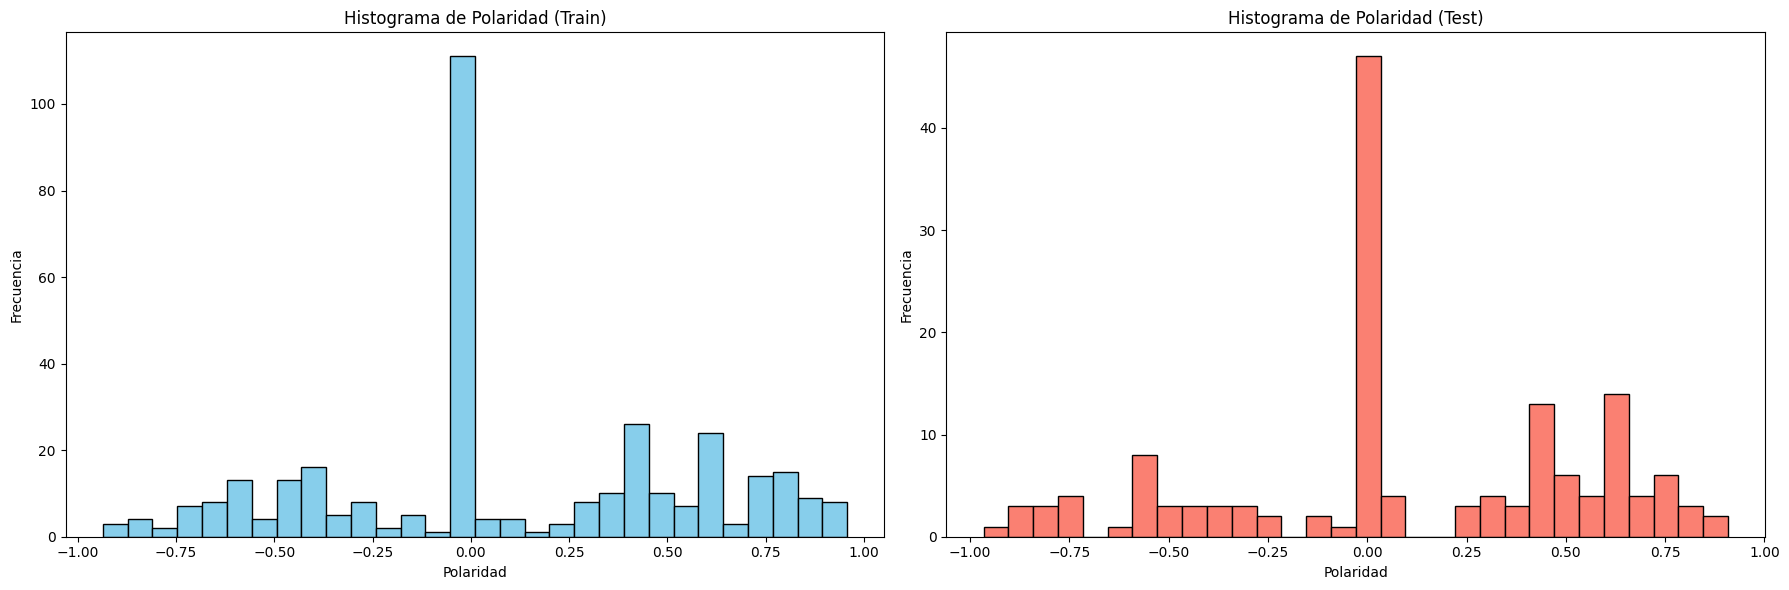

In [36]:
#Train
plt.figure(figsize=(18,6))
plt.subplot(1, 2, 1)
plt.hist(sia_y_train_pred, bins=30, color='skyblue', edgecolor='black')
plt.title('Histograma de Polaridad (Train)')
plt.xlabel('Polaridad')
plt.ylabel('Frecuencia')

#Test
plt.subplot(1, 2, 2)
plt.hist(sia_y_test_pred, bins=30, color='salmon', edgecolor='black')
plt.title('Histograma de Polaridad (Test)')
plt.xlabel('Polaridad')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

In [37]:
sia_y_train_pred[0] = sia_y_train_pred[0].apply(lambda x: vader_sentiment_clasifier(x))
sia_y_test_pred[0] = sia_y_test_pred[0].apply(lambda x: vader_sentiment_clasifier(x))

Train
              precision    recall  f1-score   support

           0       0.83      0.62      0.71       124
           2       0.64      0.72      0.68        97
           4       0.69      0.80      0.74       127

    accuracy                           0.71       348
   macro avg       0.72      0.71      0.71       348
weighted avg       0.73      0.71      0.71       348

----------------------------------------------------------
Test
              precision    recall  f1-score   support

           0       0.89      0.62      0.73        53
           2       0.57      0.64      0.61        42
           4       0.67      0.80      0.73        55

    accuracy                           0.69       150
   macro avg       0.71      0.69      0.69       150
weighted avg       0.72      0.69      0.70       150



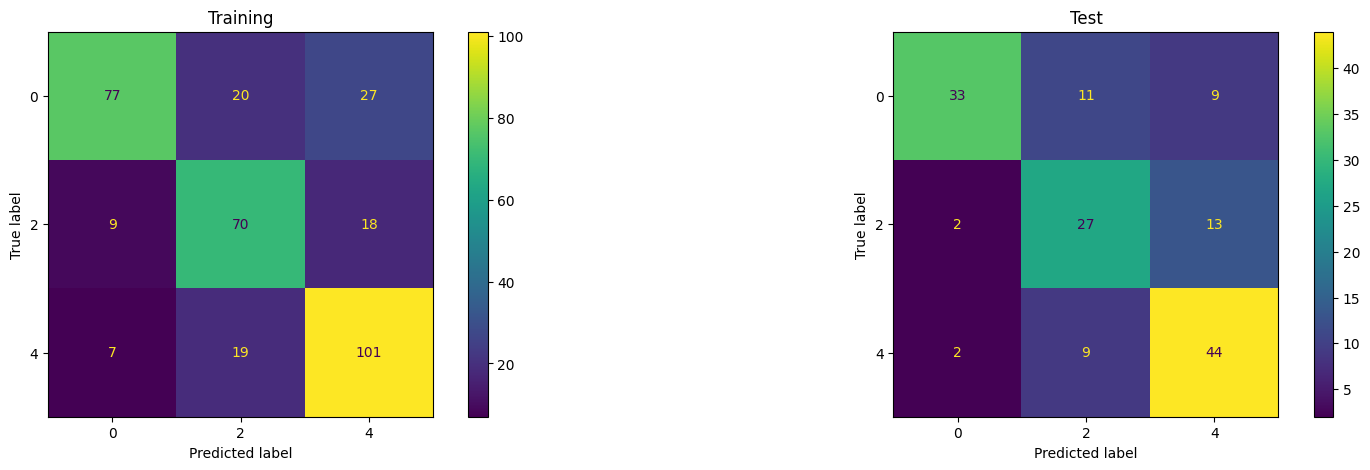

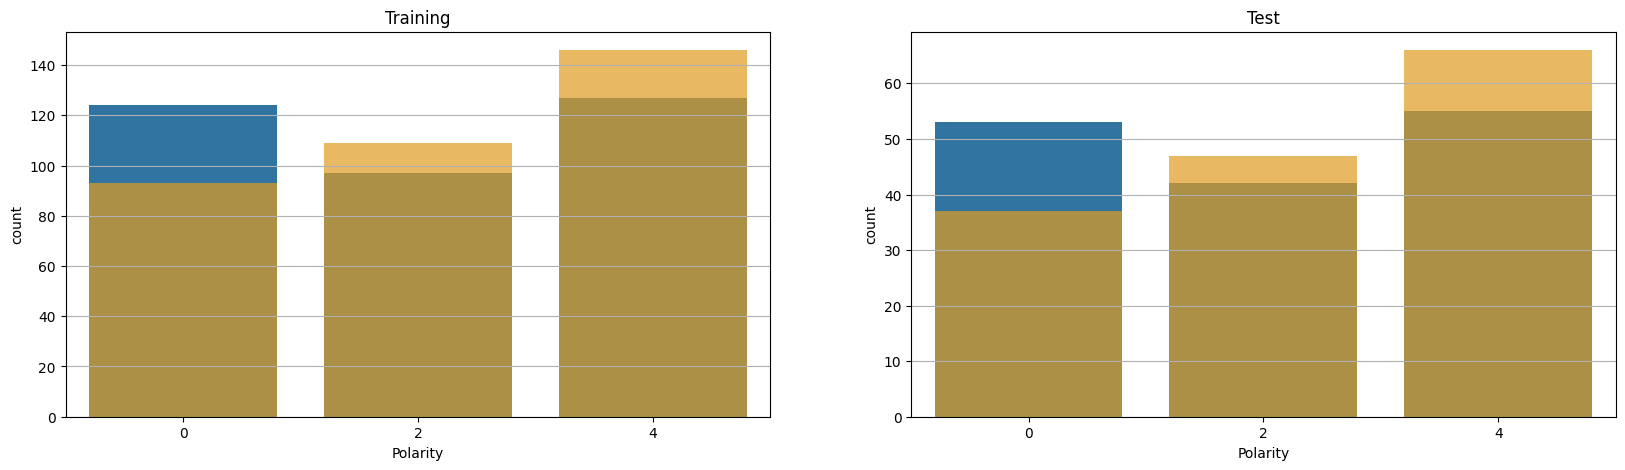

In [38]:
report(y_train, sia_y_train_pred, y_test, sia_y_test_pred)

#**TextBlob**

In [39]:
tb_y_train_pred = X_train.apply(sentyment_textblob).apply(pd.Series)
tb_y_test_pred = X_test.apply(sentyment_textblob).apply(pd.Series)

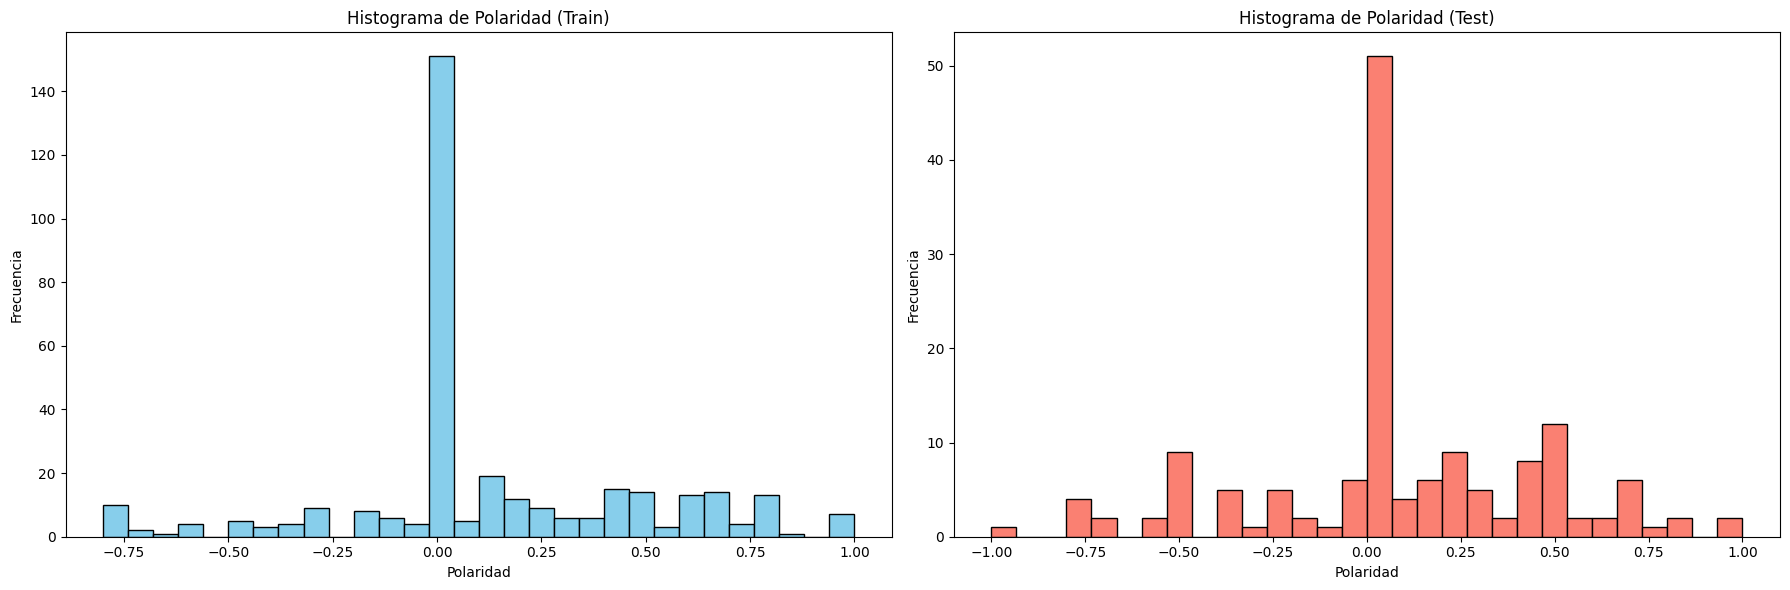

In [40]:
#Train
plt.figure(figsize=(18,6))
plt.subplot(1, 2, 1)
plt.hist(tb_y_train_pred, bins=30, color='skyblue', edgecolor='black')
plt.title('Histograma de Polaridad (Train)')
plt.xlabel('Polaridad')
plt.ylabel('Frecuencia')

#Test
plt.subplot(1, 2, 2)
plt.hist(tb_y_test_pred, bins=30, color='salmon', edgecolor='black')
plt.title('Histograma de Polaridad (Test)')
plt.xlabel('Polaridad')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

In [43]:
def feeling_clasifier(polarity):
    if polarity > 0:
        return 4
    elif polarity < 0:
        return 0
    else:
        return 2

In [44]:
tb_y_train_pred[0] = tb_y_train_pred[0].apply(lambda x: feeling_clasifier(x))
tb_y_test_pred[0] = tb_y_test_pred[0].apply(lambda x: feeling_clasifier(x))

Train
              precision    recall  f1-score   support

           0       0.81      0.38      0.52       124
           2       0.48      0.73      0.58        97
           4       0.63      0.71      0.67       127

    accuracy                           0.60       348
   macro avg       0.64      0.61      0.59       348
weighted avg       0.65      0.60      0.59       348

----------------------------------------------------------
Test
              precision    recall  f1-score   support

           0       0.76      0.55      0.64        53
           2       0.54      0.62      0.58        42
           4       0.64      0.75      0.69        55

    accuracy                           0.64       150
   macro avg       0.65      0.64      0.63       150
weighted avg       0.66      0.64      0.64       150



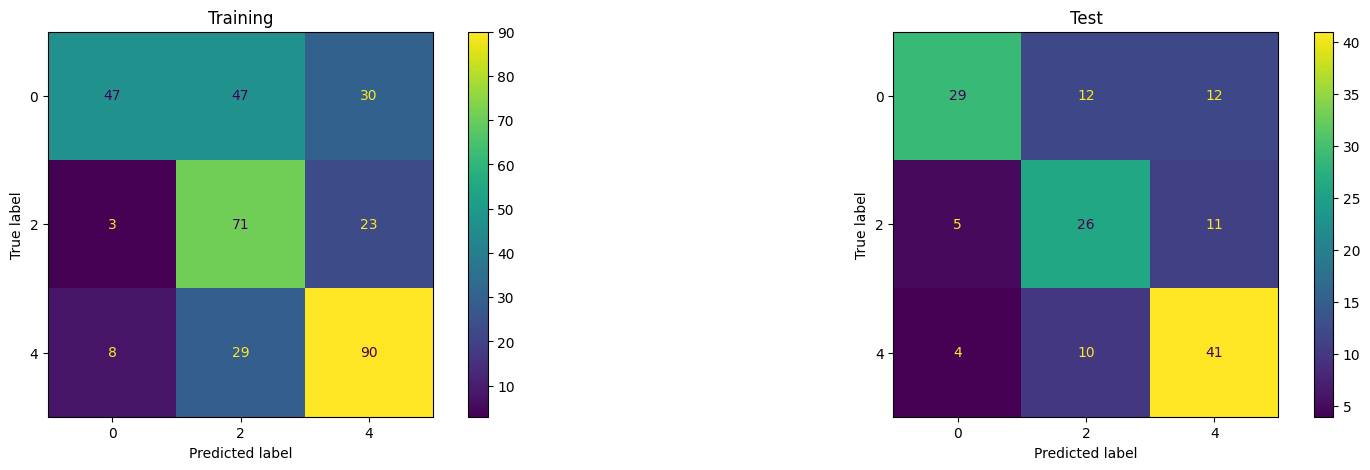

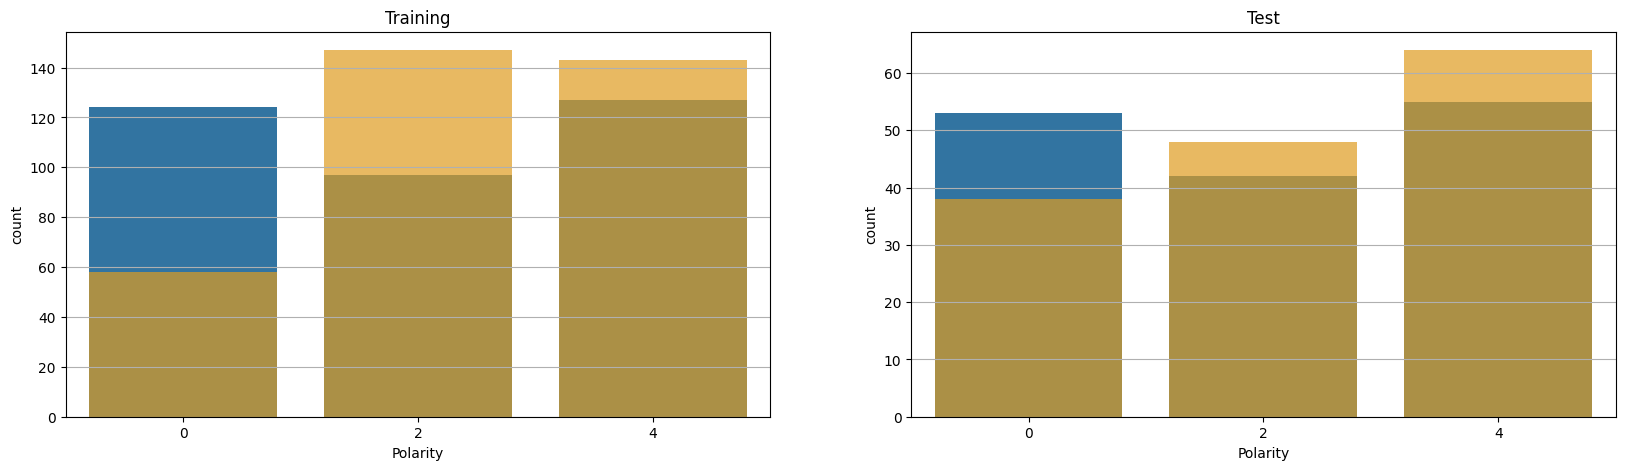

In [ ]:
report(y_train, tb_y_train_pred, y_test, tb_y_test_pred)

#**BoW + Bayes**

In [45]:
bow_vectorizer = CountVectorizer()

In [46]:
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

In [47]:
mnb_model = MultinomialNB()

In [48]:
mnb_model.fit(X_train_bow, y_train)

MultinomialNB()

In [49]:
mnb_y_train_pred = mnb_model.predict(X_train_bow)
mnb_y_test_pred = mnb_model.predict(X_test_bow)

Train
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       124
           2       0.98      0.95      0.96        97
           4       0.97      1.00      0.98       127

    accuracy                           0.98       348
   macro avg       0.98      0.97      0.98       348
weighted avg       0.98      0.98      0.98       348

----------------------------------------------------------
Test
              precision    recall  f1-score   support

           0       0.75      0.79      0.77        53
           2       0.69      0.48      0.56        42
           4       0.68      0.80      0.73        55

    accuracy                           0.71       150
   macro avg       0.71      0.69      0.69       150
weighted avg       0.71      0.71      0.70       150



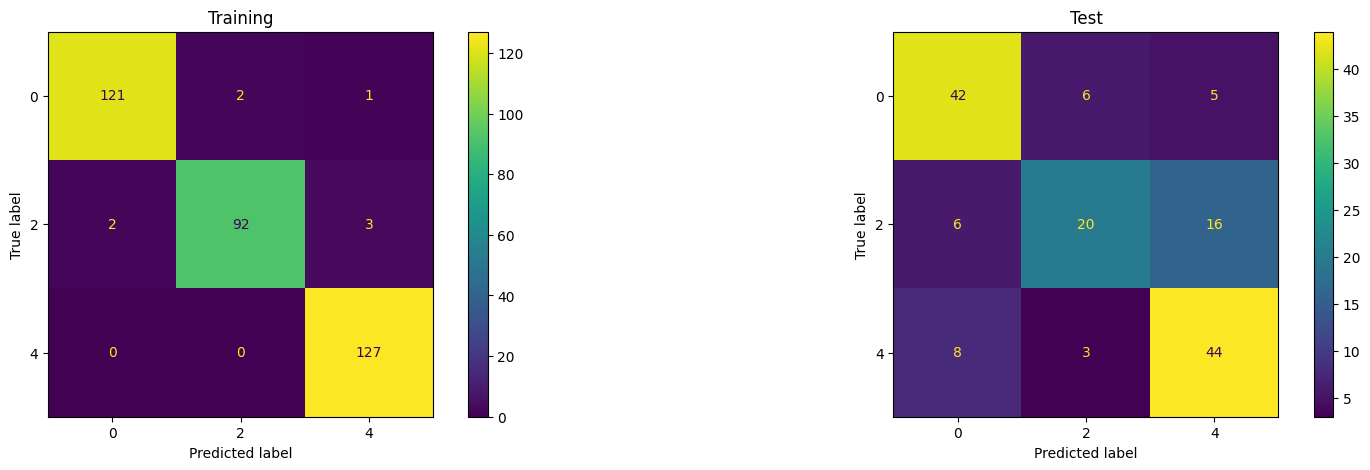

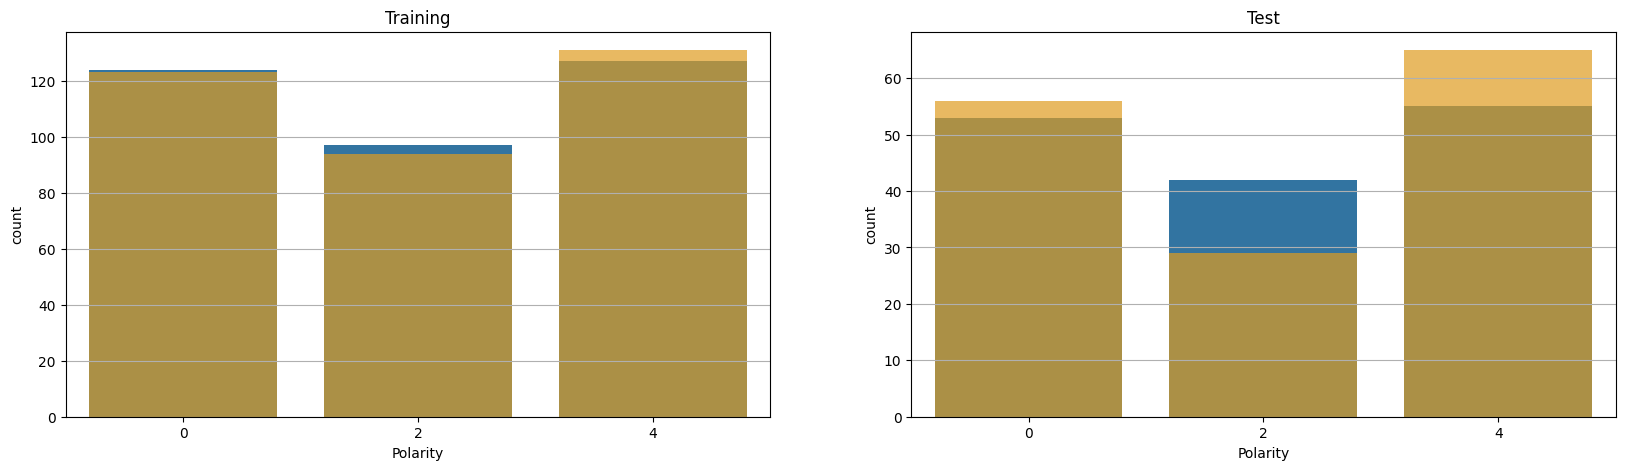

In [50]:
report(y_train, mnb_y_train_pred, y_test, mnb_y_test_pred)

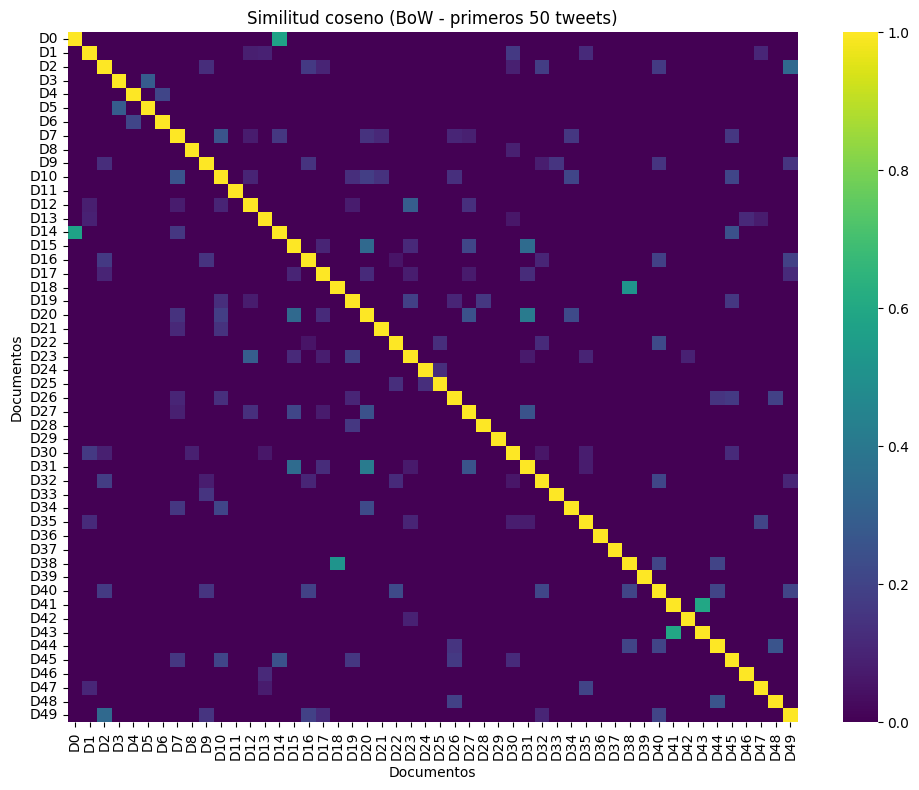

In [61]:
sample = X_train_bow[:50]

plot_cosine_similarity(sample.toarray(),
                       labels=[f"D{i}" for i in range(50)],
                       title="Similitud coseno (BoW - primeros 50 tweets)")

Se puede ver que los temas que los datos no son cercanos, lo que nos da a inferir la variedad de temas en los textos.

#**Tf-Idf + Regresión logistica**

In [51]:
tf_idf_vectorizer = TfidfVectorizer()

In [52]:
X_train_tf_idf = tf_idf_vectorizer.fit_transform(X_train)
X_test_tf_idf = tf_idf_vectorizer.transform(X_test)

In [53]:
lr_model = LogisticRegression(random_state=42, solver="liblinear", class_weight="balanced", max_iter=300)

In [54]:
lr_model.fit(X_train_tf_idf, y_train)

LogisticRegression(class_weight='balanced', max_iter=300, random_state=42,
                   solver='liblinear')

In [55]:
lr_y_train_pred = lr_model.predict(X_train_tf_idf)
lr_y_test_pred = lr_model.predict(X_test_tf_idf)

Train
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       124
           2       0.98      0.96      0.97        97
           4       0.98      1.00      0.99       127

    accuracy                           0.98       348
   macro avg       0.98      0.98      0.98       348
weighted avg       0.98      0.98      0.98       348

----------------------------------------------------------
Test
              precision    recall  f1-score   support

           0       0.80      0.83      0.81        53
           2       0.64      0.55      0.59        42
           4       0.68      0.73      0.70        55

    accuracy                           0.71       150
   macro avg       0.71      0.70      0.70       150
weighted avg       0.71      0.71      0.71       150



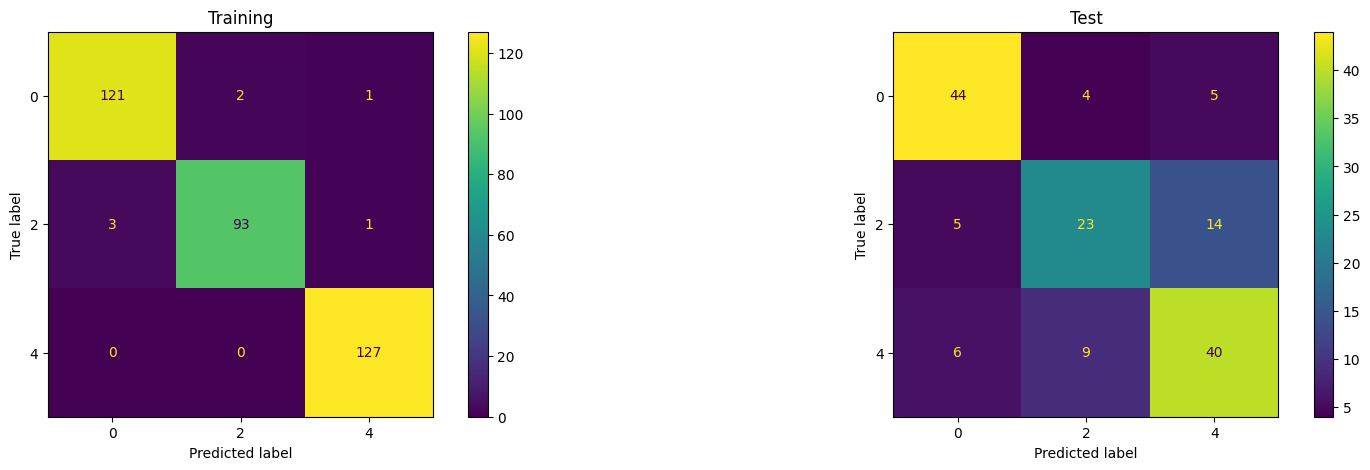

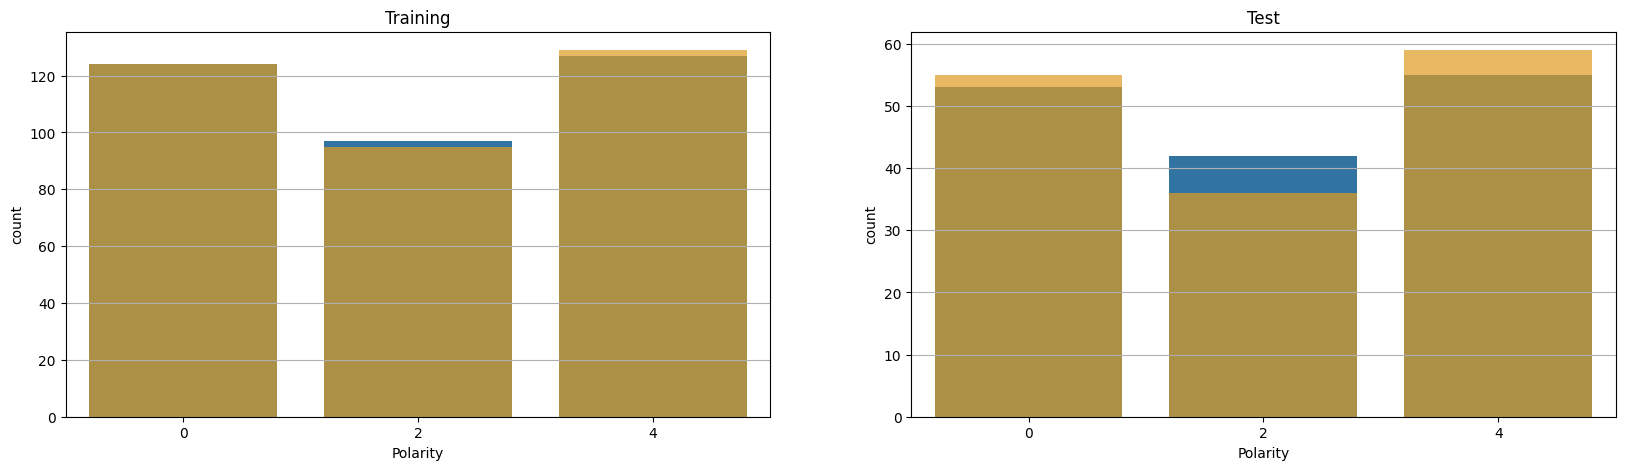

In [56]:
report(y_train, lr_y_train_pred, y_test, lr_y_test_pred)

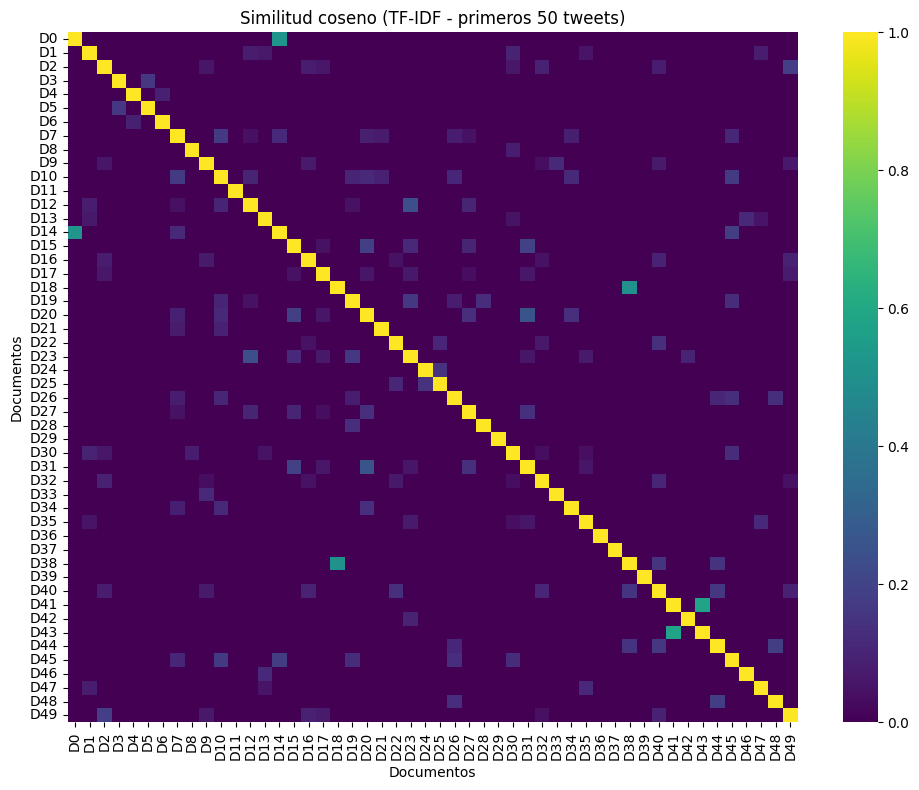

In [60]:
plot_cosine_similarity(X_train_tf_idf[:50].toarray(),
                       labels=[f"D{i}" for i in range(50)],
                       title="Similitud coseno (TF-IDF - primeros 50 tweets)")

Se puede ver que los temas que los datos no son cercanos, lo que nos da a inferir la variedad de temas en los textos.

#**Conclusiones**

###Modelos pre-entrenados

De los modelos preentrenados *Vader Sentiment* presenta una mejor performance frente a *TextBlob* con un accuracy *Train: 71 y Test: 0.69* frente a *Train: 0.60 y Test: 0.64*.

*TextBlob* presenta overfitting.

###Modelos entrenados

Estos presentan mejor performance frente a los modelos pre-entrenados.

Tienen performance similar en Training, pero en Test, se puede ver un overtting mayor en *Bow + Bayes*.

*Tf-Idf + Regresión logistica* resulta más consistente frente a *Bow + Bayes*.
